## Trabalho 1 - Fundamentos de Análise de Dados
### Implementação do algoritmo k-Nearest Neighbours (KNN) para k=1, utilizando a distância euclidiana e a distância de Mahalanobis 
#### Dataset: 'Mnist Sign Lang'

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import math
import time

### Funções 

### Manipulação de Dados

In [25]:
arq_train = 'sign_mnist_train.csv'
arq_test = 'sign_mnist_test.csv'

In [26]:
def get_all_df():
    df_train = pd.read_csv(arq_train)
    df_test = pd.read_csv(arq_test)
    df_test.drop(df_test.index[0], inplace=True)
    return df_train, df_test

def get_total_df():
    df_train, df_test = get_all_df()
    concatenated_df = pd.concat([df_train, df_test], axis=0) 
    return concatenated_df

def get_all_data():
    df_train = pd.read_csv(arq_train)
    df_test = pd.read_csv(arq_test)

    df_train.drop(df_train.index[0], inplace=True)
    y_train = df_train['label']
    df_train.drop(columns=['label'], inplace=True)
    X_train = np.asarray(df_train)

    df_test.drop(df_test.index[0], inplace=True)
    y_test = df_test['label']
    df_test.drop(columns=['label'], inplace=True)
    X_test = np.asarray(df_test) 

    return X_train, X_test, y_train, y_test

def get_x(tam, arq):
    df = pd.read_csv(arq)
    df.drop(df.index[tam+1:], inplace=True)
    df.drop(df.index[0], inplace=True)
    df.drop(columns=['label'], inplace=True)
    
    X = np.asarray(df)
    return X

def get_y(tam, arq):
    df = pd.read_csv(arq)
    df.drop(df.index[tam:], inplace=True)
    label = df['label']
    y = np.asarray(label)
    return y

def get_x_y(tam_total):
    tam_train = int(0.7 * tam_total)
    tam_test = int(tam_total - tam_train)

    X_train = get_x(tam_train, arq_train)
    y_train = get_y(tam_train, arq_train)

    X_test = get_x(tam_test, arq_test)
    y_test = get_y(tam_test, arq_test)

    return X_train, X_test, y_train, y_test

In [27]:
def get_img(index = 0):
    df,_ = get_all_df() 
    print(f"Classe dessa imagem: {df['label'].iloc[index]}")

    df.drop(columns=['label'], inplace=True)
    img = np.asarray(df.iloc[index])

    img = img.reshape((28, 28))
    plt.imshow(img, cmap="gray")
    plt.show()

def print_img(img):
    img.drop(columns=['label'], inplace=True)
    img = np.asarray(img)
    
    img = img.reshape((28, 28))
    plt.imshow(img, cmap="gray")
    plt.show()

def converting_img(img):
    final_img = img/255
    return final_img

def convert_dataset(dataset, isDf = True):
    if (isDf):
        dataset.drop(columns=['label'], inplace=True)
        dataset = np.asarray(dataset)
    arr1 = dataset[0]
    img_example = arr1
    pixels = img_example.reshape((28, 28))
    pixels = pixels/255
    pixels = pixels.flatten() 

    processed_images = np.array([pixels])
    for index, arr in enumerate(dataset):
        if index == 0:
            continue
        img_example = arr
        pixels = img_example.reshape((28, 28))
        
        pixels = pixels/255
        
        pixels = pixels.flatten() 
        processed_images = np.append(processed_images, [pixels], axis=0)

    return processed_images

### Operações 

In [28]:
def verificacao_identidade(matrix, tol=1e-10):
    if len(matrix) != len(matrix[0]):
        print("Não é possível verificar")
        return
    
    n = len(matrix)
    
    for i in range(n):
        for j in range(n):
            if ((i == j and not math.isclose(matrix[i][j], 1, abs_tol=tol)) or  (i != j and not math.isclose(matrix[i][j], 0, abs_tol=tol))):
                print("A matriz não é identidade")
                return
    
    print("A matriz é identidade")
    return

In [29]:
def euclidian_distance(x, y):
    len_x = len(x)
    len_y = len(y)
    if (len_x < len_y):
        x.resize(len_y, refcheck=False)
        x[len_x:(len_y-1)] = 0
    elif (len_y < len_x):
        y.resize(len_x, refcheck=False)
        y[len_y:(len_x-1)] = 0
    if (len(x) == len(y)):
        diff = 0
        for index, value_x in enumerate(x):
            diff+=(value_x-y[index])*(value_x-y[index])
        return np.sqrt(diff)
    else:
        print("Não foi possível calcular a distância euclidiana")
        return


def mahalanobis_distance(x, y, S):
    diff = x - y

    dist = np.sqrt(np.dot(np.dot(diff.T, S), diff))
    
    return dist


def knn (x_train, x_test, y_train, S, type):
    classes_prediction = []
    for test_vector in x_test:
        distances_classes = []
        for index, train_vector in enumerate(x_train):
            if (type == "mahalanobis"):
                dist = mahalanobis_distance(train_vector, test_vector, S)
            elif (type == "euclidiana"):
                # essa distância euclidiana foi comparada com a do scipy
                dist = euclidian_distance(train_vector, test_vector)
            else:
                raise TypeError("O argumento deve ser uma string de valor 'mahalanobis' ou 'euclidiana'")
            distances_classes.append((dist, y_train[index]))
        distances_classes.sort()
        classes_prediction.append(distances_classes[0][1])
    print(classes_prediction)
    return classes_prediction

# Funcao para calcular a matriz S necessaria para o cálculo da distancia de mahalanobis
def calculo_matriz_S (train, test):

    # A matriz S é calculada a partir do banco de dados todo
    dataset = np.concatenate((train, test), axis=0)
    cov_X = np.cov(dataset, rowvar=False)
    rank = np.linalg.matrix_rank(cov_X)
    
    # todas os vetores de imagens possuem 784 colunas, se o posto não for máximo não é possível inverter a matriz
    if (rank != 784):
        raise ValueError("Não é possível calcular a inversa desta matriz")

    else:
        print("Foi possível calcular a matriz S")
        inv_X = np.linalg.inv(cov_X)
        return inv_X

### Visualização dos Dados
#### Banco de Dados:  [Sign Language - Mnist](https://www.kaggle.com/datasets/datamunge/sign-language-mnist)
Esse banco de dados consiste em vetores que representam imagens de 784 pixels cada que estão na escala RGB (ou seja, casa pixel possui um valor inteiro entre 0 e 255, onde 0 é um pixel branco e 255, um pixel preto), que formam uma imagem de formato 28 x 28

Essas imagens foram retiradas de um banco de dados mais completo, cortadas para aparecerem apenas as mãos, reduzidas a escala de cinza e reformatadas. 


In [14]:
df = get_total_df()

df.head(15)

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179
5,16,161,168,172,173,178,184,189,193,196,...,76,74,68,62,53,55,48,238,255,255
6,8,134,134,135,135,136,137,137,138,138,...,109,102,91,65,138,189,179,181,181,179
7,22,114,42,74,99,104,109,117,127,142,...,214,218,220,223,223,225,227,227,228,228
8,3,169,174,176,180,183,185,187,188,190,...,119,118,123,120,118,114,94,74,61,57
9,3,189,189,189,190,190,191,190,190,190,...,13,53,200,204,201,201,193,175,178,156


In [15]:
df.shape

(34626, 785)

O conjunto de dados possui uma coluna de label que é a classificação da imagem. A classificação consiste em um número de 0 a 25 (sem '9': J e sem '25': Z, pois os gestos dessas letras requerem movimentação das mãos e não podem ser representados nas imagens), que idenfica aquela imagem como uma letra do alfabeto, sendo 1, a letra 'a', 2, a letra 'b', e assim sucessivamente.

In [16]:
df['label'].head(20)

0      3
1      6
2      2
3      2
4     13
5     16
6      8
7     22
8      3
9      3
10    18
11    10
12    16
13    22
14    20
15    16
16    17
17    13
18    13
19    19
Name: label, dtype: int64

Como a imagem é representada no dataset

In [17]:
df.head(1)

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202


Exemplo de imagem (no caso, um G)

Classe dessa imagem: 6


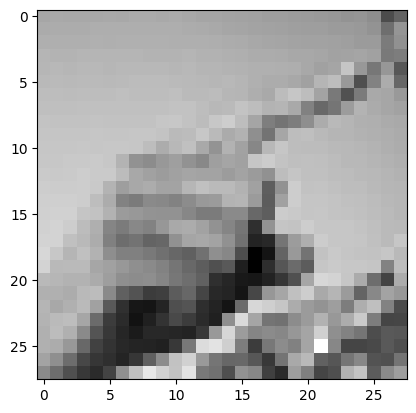

In [18]:
get_img(1)

### KNN

### Distância de Mahalanobis

##### Cálculo da matriz S
Para o cálculo da Distância de Mahalanobis, é necessário calcular a inversa da matriz S de covariância do banco de dados. O processo é descrito a seguir, com o dataset completo:

In [19]:
df = get_total_df()

A matriz de covariância é calculada 

In [21]:
# Calculando a matriz de covariância do dataset 

cov_X = np.cov(df, rowvar=False)
print(cov_X.shape)


(785, 785)


Depois disso é feito um processo de verificação da matriz de covariância (esse processo é feito também na função de cálculo de covariância dos testes):
Verificando o posto da matriz. Ela precisa ser posto máximo (784, quantidade de colunas), para que possa ter determinante 0 e ser invertível para o cálculo da distância de Mahalanobis

In [22]:
rank = np.linalg.matrix_rank(cov_X)
print(rank)

785


Verificando o determinante da matriz de covariância com slogdet, indicada para matrizes de tamanho grande, pois utilizando a função det o resultado não era satisfatório (era sempre 0)

In [23]:
print(cov_X.shape)
det_X = np.linalg.slogdet(cov_X)
print(det_X)

(785, 785)
SlogdetResult(sign=1.0, logabsdet=3309.8051948172483)


Aqui a inversa é calculada e também verificada com a função identidade que tem como objetivo retornar se p (o produto das matrizes de covariância com a sua respectiva inversa) é identidade

In [30]:
inv_X = np.linalg.inv(cov_X)

p = np.dot(cov_X, inv_X)

verificacao_identidade(p)

A matriz é identidade


#### Cálculo da Distância de Mahalanobis
Nesta sessão serão feitos alguns testes com o KNN com a Distância de Mahalanobis, uma vez que não foi possível calcular o KNN do dataset total para essa distância em tempo hábil, por conta do tamanho do dataset e dos cálculos custosos entre matrizes 

Uma observação interessante foi possível de ser observada: foram feitos testes com amostras de quantidades 10, 30, 100 e 300, porém, não foi possível utilizar a distância de Mahalanobis em nenhum desses testes. Isso ocorreu porque as matrizes de covariâncias dessas matrizes de amostras não possuiam posto máximo, logo, possuiam colunas LD e não poderiam ser invertidas. 

In [8]:
def calculo_rmse(result, y_test):
    diff = (np.array(result) - np.array(y_test)) ** 2

    mean_diff = np.mean(diff)

    rmse = np.sqrt(mean_diff)

    return rmse

In [96]:
def knn_mahalanobis(tam_amostra):
    start_time = time.time()
    X_train, X_test, y_train, y_test = get_x_y(tam_amostra)
    S = calculo_matriz_S(X_train, X_test)
    result = knn(X_train, X_test, y_train, S, type="mahalanobis")
    end_time = time.time()
    print(f"Tempo de execução: {end_time - start_time:.6f} segundos")
    rmse = calculo_rmse(result, y_test)
    print(f"O valor do RMSE é: {rmse}.")
    return result, rmse

result_10, rmse_10 = knn_mahalanobis(10)

[[1603.77777778 1918.11111111 1757.22222222 ...   96.77777778
   235.55555556 -123.66666667]
 [1918.11111111 2787.28888889 2405.04444444 ... -123.15555556
    69.         -305.77777778]
 [1757.22222222 2405.04444444 2116.23333333 ...   15.15555556
   181.27777778 -176.94444444]
 ...
 [  96.77777778 -123.15555556   15.15555556 ... 1805.95555556
  1624.33333333 1251.22222222]
 [ 235.55555556   69.          181.27777778 ... 1624.33333333
  1563.83333333 1224.05555556]
 [-123.66666667 -305.77777778 -176.94444444 ... 1251.22222222
  1224.05555556 1399.16666667]]


ValueError: Não é possível calcular a inversa desta matriz

In [104]:
result_1000, rmse_1000 = knn_mahalanobis(1000)

Foi possível calcular a matriz S
[0, 0, 0, 0, 0, 0, 0, 16, 0, 0, 16, 0, 0, 0, 0, 0, 0, 0, 16, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 21, 0, 0, 0, 0, 0, 0, 0, 0, 21, 0, 21, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 16, 0, 0, 0, 0, 0, 0, 0, 0, 0, 16, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 19, 20, 16, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 16, 21, 0, 0, 0, 0, 0, 0, 16, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 21, 21, 0, 0, 0, 0, 16, 0, 0, 0, 0, 0, 16, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 21, 21, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 16, 0, 0, 0, 0, 0, 0, 0, 0, 0, 16, 0, 0, 0, 0, 16, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 16, 0, 21, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 16, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 16, 16, 0, 0, 0, 0, 16, 16, 0, 0, 0, 0, 0, 21, 21, 0, 21, 0, 0, 0, 0, 0, 0, 0, 0, 0, 21, 0, 16, 0, 0, 0, 0, 16, 0, 0, 0, 13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Tempo de execução: 41.224112 

In [105]:
result_3000, rmse_3000 = knn_mahalanobis(3000)

Foi possível calcular a matriz S
[21, 16, 6, 21, 16, 16, 23, 21, 21, 23, 21, 21, 16, 21, 23, 2, 20, 21, 21, 21, 21, 23, 21, 16, 23, 16, 23, 21, 21, 21, 21, 23, 21, 23, 21, 21, 3, 21, 20, 20, 21, 16, 21, 16, 21, 21, 21, 21, 23, 21, 23, 21, 21, 16, 21, 21, 21, 21, 23, 21, 23, 21, 23, 24, 21, 20, 23, 21, 10, 16, 23, 21, 21, 23, 21, 21, 21, 23, 21, 23, 20, 16, 16, 14, 23, 21, 21, 21, 21, 23, 14, 21, 24, 21, 21, 20, 20, 8, 23, 23, 21, 21, 21, 21, 19, 23, 23, 21, 23, 21, 23, 23, 16, 21, 21, 21, 21, 21, 21, 21, 16, 16, 21, 20, 21, 23, 16, 21, 23, 21, 23, 21, 21, 20, 21, 16, 16, 21, 16, 23, 21, 23, 21, 15, 21, 19, 21, 21, 16, 23, 21, 22, 21, 21, 21, 20, 16, 21, 24, 20, 21, 23, 21, 21, 21, 20, 16, 23, 21, 16, 21, 23, 21, 21, 23, 21, 23, 21, 14, 23, 21, 16, 16, 21, 21, 21, 21, 23, 21, 21, 16, 13, 21, 21, 23, 21, 21, 21, 21, 21, 21, 23, 21, 2, 21, 21, 23, 17, 20, 21, 23, 21, 23, 2, 21, 21, 23, 21, 21, 21, 23, 21, 21, 21, 23, 21, 16, 21, 23, 21, 20, 10, 23, 16, 21, 21, 21, 23, 21, 16, 21, 16, 21, 

In [124]:
result_5000, rmse_5000 = knn_mahalanobis(5000)

Foi possível calcular a matriz S
[21, 2, 7, 14, 23, 20, 23, 14, 21, 16, 21, 23, 16, 23, 23, 5, 20, 21, 21, 21, 12, 16, 21, 20, 23, 16, 23, 21, 20, 21, 21, 23, 21, 16, 21, 2, 22, 21, 16, 23, 21, 16, 21, 16, 24, 21, 21, 21, 23, 14, 23, 21, 21, 23, 21, 23, 21, 21, 23, 21, 23, 23, 23, 23, 1, 2, 23, 21, 10, 16, 23, 21, 2, 14, 21, 21, 21, 23, 21, 23, 20, 23, 17, 14, 23, 21, 21, 21, 20, 23, 14, 21, 24, 21, 23, 20, 20, 21, 23, 23, 21, 21, 21, 21, 15, 16, 23, 21, 23, 21, 23, 23, 21, 21, 21, 21, 21, 21, 21, 23, 16, 16, 21, 20, 21, 23, 17, 23, 23, 21, 23, 23, 21, 20, 21, 16, 23, 23, 16, 21, 21, 23, 21, 23, 21, 19, 21, 21, 21, 23, 21, 22, 21, 23, 20, 20, 20, 21, 24, 20, 23, 23, 21, 21, 23, 20, 14, 23, 21, 2, 21, 23, 21, 23, 21, 21, 23, 21, 14, 23, 21, 16, 20, 21, 21, 21, 21, 23, 21, 21, 16, 13, 21, 2, 23, 21, 21, 23, 21, 21, 21, 23, 20, 2, 23, 21, 23, 2, 20, 21, 23, 21, 23, 2, 21, 21, 23, 21, 23, 21, 23, 23, 21, 21, 23, 23, 23, 21, 22, 21, 21, 19, 23, 24, 0, 21, 21, 23, 21, 16, 21, 16, 21, 21, 2, 

In [125]:
result_10000, rmse_10000 = knn_mahalanobis(10000)

Foi possível calcular a matriz S
[24, 4, 7, 14, 24, 24, 24, 14, 17, 24, 24, 23, 16, 21, 21, 5, 20, 21, 21, 21, 20, 24, 22, 22, 24, 21, 23, 21, 6, 21, 18, 23, 12, 7, 21, 2, 22, 21, 16, 23, 21, 24, 21, 23, 24, 21, 21, 21, 23, 24, 23, 24, 21, 23, 21, 24, 21, 24, 23, 2, 23, 21, 23, 24, 1, 2, 23, 2, 10, 21, 16, 21, 16, 14, 21, 24, 21, 21, 23, 23, 24, 16, 17, 14, 23, 21, 21, 21, 22, 24, 20, 17, 12, 18, 21, 20, 20, 21, 23, 21, 21, 21, 22, 21, 13, 23, 22, 21, 21, 21, 2, 23, 21, 21, 21, 21, 21, 21, 21, 23, 21, 21, 21, 20, 24, 23, 17, 24, 23, 21, 12, 24, 22, 24, 21, 22, 23, 23, 16, 21, 21, 17, 21, 23, 21, 6, 21, 21, 16, 16, 16, 22, 7, 23, 21, 20, 22, 13, 17, 21, 16, 23, 21, 21, 23, 22, 19, 24, 24, 24, 21, 16, 21, 21, 8, 21, 23, 21, 20, 23, 21, 16, 22, 24, 24, 21, 21, 23, 21, 21, 16, 13, 21, 16, 23, 21, 21, 21, 21, 17, 24, 23, 21, 24, 21, 21, 23, 24, 21, 22, 24, 21, 13, 2, 21, 0, 23, 21, 11, 21, 23, 2, 21, 24, 23, 24, 7, 21, 21, 21, 21, 6, 23, 24, 0, 21, 21, 23, 21, 23, 21, 16, 21, 21, 2, 24, 16,

In [126]:
result_20000, rmse_20000 = knn_mahalanobis(20000)

Foi possível calcular a matriz S
[24, 4, 7, 14, 23, 22, 16, 14, 17, 10, 16, 5, 6, 21, 21, 5, 20, 21, 21, 21, 20, 24, 22, 12, 14, 21, 23, 16, 21, 21, 21, 24, 12, 8, 21, 2, 22, 17, 16, 23, 21, 24, 21, 23, 24, 21, 21, 21, 23, 21, 14, 21, 21, 16, 3, 16, 21, 2, 23, 21, 23, 21, 12, 8, 15, 21, 23, 22, 10, 16, 16, 16, 16, 14, 21, 14, 21, 21, 23, 18, 21, 14, 17, 14, 23, 21, 21, 23, 22, 8, 20, 17, 14, 21, 21, 20, 20, 21, 16, 21, 22, 21, 22, 21, 18, 23, 22, 21, 21, 21, 2, 22, 21, 21, 21, 23, 21, 21, 21, 23, 21, 21, 21, 16, 14, 15, 17, 24, 23, 21, 12, 16, 22, 1, 21, 22, 16, 23, 19, 21, 21, 17, 21, 23, 4, 6, 21, 21, 21, 21, 7, 22, 7, 23, 21, 2, 22, 13, 17, 21, 7, 23, 22, 21, 23, 22, 21, 23, 16, 21, 21, 16, 21, 20, 1, 17, 23, 5, 20, 24, 10, 23, 23, 10, 16, 21, 16, 23, 21, 22, 16, 14, 21, 16, 23, 15, 21, 21, 21, 17, 21, 22, 21, 23, 21, 21, 23, 24, 21, 22, 16, 21, 13, 2, 21, 0, 23, 21, 11, 22, 23, 2, 21, 18, 23, 10, 23, 21, 21, 21, 21, 6, 23, 24, 21, 21, 21, 15, 21, 16, 21, 16, 21, 16, 21, 16, 21, 11,

In [9]:
def knn_euclidian(tam_amostra):
    start_time = time.time()
    X_train, X_test, y_train, y_test = get_x_y(tam_amostra)
    result = knn(X_train, X_test, y_train, S = 0, type="euclidiana")
    end_time = time.time()
    print(f"Tempo de execução: {end_time - start_time:.6f} segundos")
    rmse = calculo_rmse(result, y_test)
    print(f"O valor do RMSE é: {rmse}.")
    return result, rmse

In [ ]:
result_1000_euclidian, rmse_1000_euclidian = knn_euclidian(1000)

[11, 19, 6, 14, 22, 22, 19, 14, 8, 6, 11, 6, 11, 20, 15, 2, 2, 0, 19, 18, 7, 23, 21, 16, 5, 23, 20, 2, 20, 8, 11, 16, 21, 11, 14, 16, 3, 4, 19, 13, 7, 11, 1, 0, 6, 21, 15, 19, 4, 16, 8, 14, 21, 3, 11, 22, 14, 0, 0, 2, 4, 12, 23, 10, 11, 12, 3, 19, 15, 21, 10, 5, 24, 20, 21, 5, 12, 13, 3, 21, 5, 21, 16, 11, 19, 20, 19, 0, 11, 10, 20, 8, 20, 11, 14, 20, 20, 12, 23, 15, 15, 0, 23, 23, 10, 18, 20, 23, 10, 3, 22, 3, 20, 0, 19, 19, 4, 23, 10, 24, 17, 16, 13, 15, 11, 16, 16, 19, 8, 11, 15, 4, 4, 4, 23, 8, 22, 5, 23, 18, 19, 16, 10, 15, 15, 6, 15, 20, 24, 24, 20, 18, 0, 11, 14, 0, 16, 15, 11, 21, 14, 23, 16, 14, 4, 22, 7, 3, 6, 0, 18, 6, 24, 18, 0, 24, 15, 6, 18, 3, 7, 21, 7, 4, 0, 1, 21, 22, 21, 3, 20, 20, 8, 20, 1, 14, 13, 20, 1, 8, 0, 13, 15, 13, 6, 3, 21, 6, 21, 22, 7, 0, 12, 4, 10, 19, 1, 4, 14, 3, 20, 22, 0, 2, 14, 4, 18, 11, 14, 16, 11, 19, 4, 6, 14, 23, 21, 3, 8, 2, 13, 4, 16, 17, 15, 5, 15, 2, 23, 14, 14, 7, 18, 11, 18, 8, 12, 8, 2, 5, 20, 18, 14, 15, 6, 4, 21, 21, 10, 6, 16, 21, 22, 

In [ ]:
result_3000_euclidian, rmse_3000_euclidian = knn_euclidian(3000)

[3, 7, 6, 18, 17, 17, 21, 18, 22, 5, 5, 10, 0, 12, 4, 5, 2, 0, 19, 24, 16, 12, 11, 16, 17, 23, 5, 20, 20, 8, 2, 16, 21, 11, 18, 16, 3, 15, 19, 13, 10, 5, 5, 21, 20, 21, 20, 0, 4, 16, 8, 7, 11, 11, 22, 17, 10, 15, 0, 19, 1, 12, 23, 22, 14, 13, 22, 22, 10, 21, 17, 7, 24, 14, 21, 5, 19, 2, 3, 21, 5, 14, 2, 14, 24, 15, 16, 18, 0, 22, 2, 17, 20, 15, 23, 20, 20, 6, 6, 11, 2, 0, 5, 10, 15, 16, 0, 12, 17, 21, 19, 4, 19, 0, 17, 6, 22, 8, 8, 2, 12, 22, 17, 15, 5, 16, 2, 24, 8, 11, 24, 10, 4, 15, 3, 11, 17, 15, 23, 16, 19, 19, 10, 15, 7, 6, 4, 11, 21, 24, 10, 18, 8, 1, 14, 0, 16, 10, 10, 21, 21, 23, 21, 14, 22, 18, 18, 12, 22, 19, 11, 6, 24, 18, 5, 24, 15, 10, 2, 18, 10, 23, 21, 15, 0, 23, 21, 17, 0, 3, 16, 20, 14, 20, 5, 1, 19, 23, 17, 22, 21, 12, 5, 19, 6, 18, 5, 18, 21, 0, 7, 0, 11, 14, 10, 5, 5, 4, 23, 2, 18, 2, 0, 1, 14, 23, 13, 13, 22, 3, 22, 10, 22, 20, 0, 5, 1, 11, 0, 6, 24, 4, 16, 8, 22, 17, 10, 5, 23, 22, 15, 15, 18, 20, 18, 8, 8, 11, 16, 5, 2, 22, 13, 3, 23, 8, 21, 21, 17, 21, 3, 7, 16

In [ ]:
result_5000_euclidian, rmse_5000_euclidian = knn_euclidian(5000)

[3, 2, 6, 18, 17, 17, 21, 18, 22, 5, 20, 10, 8, 24, 4, 5, 2, 0, 12, 24, 16, 12, 3, 16, 17, 23, 10, 20, 3, 8, 2, 20, 1, 11, 18, 16, 3, 15, 19, 13, 10, 5, 10, 21, 20, 21, 10, 0, 2, 17, 6, 0, 17, 11, 22, 17, 21, 17, 3, 19, 2, 12, 3, 12, 14, 3, 22, 0, 10, 21, 7, 7, 24, 14, 12, 17, 0, 2, 3, 16, 5, 14, 11, 14, 24, 12, 16, 24, 0, 12, 2, 17, 3, 19, 8, 23, 23, 8, 6, 11, 1, 11, 1, 10, 15, 16, 0, 17, 7, 11, 19, 23, 16, 11, 17, 14, 3, 8, 18, 2, 13, 22, 3, 15, 5, 21, 11, 24, 8, 11, 24, 10, 4, 15, 3, 3, 17, 15, 18, 16, 19, 19, 19, 15, 7, 7, 24, 11, 21, 3, 1, 0, 8, 16, 14, 11, 16, 24, 10, 21, 8, 2, 20, 14, 22, 18, 18, 12, 11, 19, 11, 6, 24, 11, 18, 17, 15, 10, 2, 23, 10, 3, 21, 15, 0, 19, 21, 17, 0, 3, 16, 23, 10, 21, 5, 1, 17, 23, 17, 22, 19, 12, 5, 3, 4, 3, 5, 18, 21, 0, 7, 0, 11, 14, 10, 5, 5, 2, 23, 1, 11, 2, 0, 1, 12, 23, 13, 13, 22, 3, 22, 10, 22, 24, 0, 5, 1, 11, 0, 6, 3, 1, 16, 8, 13, 17, 10, 5, 3, 22, 13, 24, 18, 20, 18, 1, 16, 11, 18, 7, 2, 6, 13, 3, 23, 1, 21, 21, 7, 21, 3, 7, 16, 24, 10, 

In [12]:
result_10000_euclidian, rmse_10000_euclidian = knn_euclidian(10000)

[3, 2, 13, 18, 7, 7, 3, 18, 16, 5, 20, 14, 0, 24, 4, 5, 2, 0, 0, 11, 5, 12, 22, 16, 13, 24, 12, 6, 3, 8, 2, 17, 12, 8, 4, 16, 2, 0, 3, 13, 22, 5, 12, 3, 19, 21, 10, 23, 3, 14, 13, 18, 1, 20, 21, 7, 21, 5, 3, 3, 3, 12, 3, 12, 14, 3, 1, 17, 10, 21, 20, 3, 16, 14, 6, 13, 4, 1, 6, 2, 8, 14, 10, 14, 8, 12, 16, 1, 13, 12, 3, 16, 3, 19, 8, 23, 23, 17, 18, 7, 1, 11, 8, 18, 15, 16, 0, 17, 20, 14, 19, 23, 21, 0, 7, 14, 3, 17, 18, 16, 14, 22, 3, 15, 5, 21, 6, 24, 8, 21, 24, 20, 4, 16, 1, 3, 23, 21, 18, 16, 17, 19, 19, 15, 7, 21, 24, 20, 23, 22, 13, 0, 8, 22, 14, 11, 16, 13, 13, 21, 8, 2, 20, 1, 11, 16, 18, 12, 10, 4, 11, 6, 24, 11, 8, 17, 15, 14, 2, 0, 18, 24, 23, 15, 0, 14, 6, 14, 8, 11, 16, 8, 12, 21, 12, 0, 14, 4, 17, 6, 19, 24, 24, 22, 22, 3, 15, 4, 21, 0, 7, 16, 2, 14, 10, 0, 12, 3, 17, 1, 17, 23, 8, 1, 1, 23, 13, 13, 22, 23, 22, 6, 7, 24, 19, 0, 1, 1, 13, 6, 2, 1, 0, 8, 0, 3, 10, 5, 3, 22, 13, 8, 18, 20, 20, 1, 16, 7, 12, 7, 2, 6, 13, 3, 11, 1, 21, 20, 20, 21, 3, 10, 16, 22, 10, 17, 10, 4, 

#### Análise dos Resultados:

Neste trabalho foi possível observar o comportamento geral do KNN e comparar diferentes cálculos de distâncias para o mesmo modelo.

Comparando os RMSE como indicativo de acurácia das duas soluções, pode-se aferir que a distância euclidiana e a distância de mahalanobis têm uma acurácia parecida, uma vez que os resultados dos cálculos de RMSE estão em um intervalo entre 9 e 13, sendo o menor valor alcançado com o cálculo da distância euclidiana e, o maior, com o cálculo da distância de Mahalanobis. Desse modo, nota-se, também, que a quantidade de dados, apesar de ter sido variada num intervalo bastante grande (1000 a 20000), não interferiu tando no resultado do RMSE. 

Porém, apesar de serem números de RMSE próximos, eles podem ser considerados relativamente distantes, uma vez que os valores do vetor de y não têm uma grande variabilidade (sendo números inteiros entre 0 e 25). 

Ademais, considerando que o escopo deste trabalho limita os testes a k = 1, não é possível constatar neste trabalho o quanto, apesar de a variabilidade da quantidade de dados não ter interferido tanto no resultado do RMSE, a variação desse valor iria interferir muito no resultado; esta sendo uma forma de expandir os estudos sobre o KNN.

Com relação a análise de tempo de execução do modelo, foi possível perceber que o crescimento de tempo de execução do modelo em ambas as distâncias é relativamente parecido, porém, pelo fato do cálculo entre matrizes ser mais custoso, o tempo de execução do modelo com a distância de mahalanobis é maior.

Além disso, é interessante destacar que foi preciso uma série de ajustes nas funções do modelo com a distância de Mahalanobis para que o código pudesse rodar em tempo hábil. 